In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion

In [3]:
from sklearn.base import BaseEstimator, TransformerMixin

In [4]:
from sklearn.linear_model import LogisticRegression

In [5]:
import matplotlib.pyplot as plt

In [6]:
import itertools

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [243]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, roc_curve, auc
from sklearn.metrics import classification_report, precision_recall_curve, confusion_matrix

In [242]:
from sklearn.metrics import SCORERS

In [18]:
from sklearn.preprocessing import StandardScaler

In [9]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split

In [10]:
import xgboost as xgb

In [64]:
import seaborn as sns

#### Функции, для использования в заданиях

In [79]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [136]:
def roc_auc_curve_draw(y_test, y_pred):
    sns.set(font_scale=1.5)
    sns.set_color_codes("muted")

    plt.figure(figsize=(10, 8))
    fpr, tpr, thresholds_ = roc_curve(y_test, y_pred, pos_label=1)# C = 0.1
    roc_auc = auc(fpr, tpr)
    lw = 2

    plt.plot(fpr, 
             tpr, 
             lw=lw, 
             label="ROC curve (area = %0.2f)" % roc_auc)    
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    #plt.savefig("ROC.png")
    plt.show()
    return roc_auc

In [103]:
def precision_recall_draw(y_test, y_pred, precision, recall, n=-1):
    plt.plot(recall[:n],precision[:n] )
    plt.title(' точность/полнота')
    plt.xlabel(' полнота')
    plt.ylabel(' точность')
    plt.grid('On')
    plt.show()

## Домашнее задание

1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)
2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)
3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты. 
4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3
5. (опционально) Еще раз провести оценку экономической эффективности

### загрузка и предобработка датасета

Загрузка датасета

In [13]:
df = pd.read_csv("churn_data.csv", index_col='RowNumber')

In [14]:
df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Характеристики данных в датасете

In [15]:
df.describe()

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


Проверка соотношения классов

In [16]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

Проверка датасета га NaN значения

In [17]:
df.isna().sum()

CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

----------

### Задание 1

1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)

Создаем обработчики, которые будут использованы в пайплайне.

In [30]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    """Implements get_dummies method for Categorial columns."""
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

Создаем список категориальных и непрерывных переменных.

In [20]:
df.columns

Index(['CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age',
       'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
       'EstimatedSalary', 'Exited'],
      dtype='object')

In [21]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

Часть полей не содержит какой-либо ниформации влияющей на результат и поэтому они будут отброшены.

In [22]:
y = df['Exited']

In [23]:
X = df.drop(['CustomerId', 'Surname', 'Exited'], axis = 1)

Разбиваем обработанный датасет на тестовую и тренировочную выборки.

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=53)

In [27]:
X.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
RowNumber,,,,,,,,,,
1,619,France,Female,42,2,0.00,1,1,1,101348.88
2,608,Spain,Female,41,1,83807.86,1,0,1,112542.58
3,502,France,Female,42,8,159660.80,3,1,0,113931.57
4,699,France,Female,39,1,0.00,2,0,0,93826.63
5,850,Spain,Female,43,2,125510.82,1,1,1,79084.10


In [28]:
y.head()

RowNumber
1    1
2    0
3    1
4    0
5    0
Name: Exited, dtype: int64

Создаем пайплайн для последующего процессинга

In [31]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))

In [32]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

In [ ]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42,class_weight={0:1,1:4} )),
])

Проверка соотношения классов для последующего назначения весов

In [46]:
ratio = df['Exited'][df['Exited']== 1].value_counts()/df['Exited'].count()
ratio_1 = 1/ratio
ratio_0 = 1/(1 - ratio)

In [47]:
ratio_1[1]

4.909180166912126

In [48]:
ratio_0[1]

1.2558081125204068

Создание датафрэйма для хранения результатов

In [157]:
results_df = pd.DataFrame(columns = ['Model','threshold','Recall', 'Precision','F1 max', 'Auc'])

In [158]:
results_df.head()

,Model,threshold,Recall,Precision,F1 max,Auc


Для выполнения домашнего задания будем использовать несколько вариантов моделей:
- градиентный бустинг
- random Forest

#### Random Forest

Объединим все это в единый пайплайн

In [66]:
pipeline_rf = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42,class_weight={0:ratio_0[1],1:ratio_1[1]} )),
])

Тренировка модели

In [67]:
pipeline_rf.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

Получение вероятностей на тестовой выборке

In [74]:
y_pred_rf = pipeline_rf.predict_proba(X_test)[:, 1]
y_pred_rf[:15]

array([0.01, 0.74, 0.03, 0.2 , 0.27, 0.61, 0.1 , 0.05, 0.04, 0.53, 0.31,
       0.02, 0.52, 0.09, 0.22])

Определение метрик для последующего анализа.

In [75]:
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_test, y_pred_rf)

In [76]:
fscore_rf = (2 * precision_rf * recall_rf) / (precision_rf + recall_rf)

Определение индекса и связанных величин для высшего значения F1 метрики

In [81]:
ix_rf = np.argmax(fscore_rf)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_rf[ix_rf], 
                                                                        fscore_rf[ix_rf],
                                                                        precision_rf[ix_rf],
                                                                        recall_rf[ix_rf]))

Best Threshold=0.370000, F-Score=0.614, Precision=0.659, Recall=0.575


Построение матрицы ошибок

Confusion matrix, without normalization
[[1836  146]
 [ 227  291]]


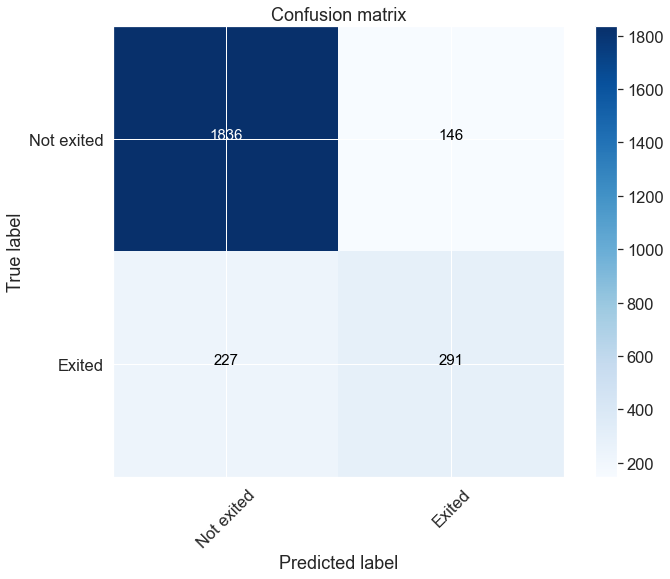

In [82]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_rf = confusion_matrix(y_test, y_pred_rf>thresholds_rf[ix_rf])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_rf, classes=['Not exited', 'Exited'],
                      title='Confusion matrix')
#plt.savefig("conf_matrix.png")
plt.show()

Построение графика точность/полнота

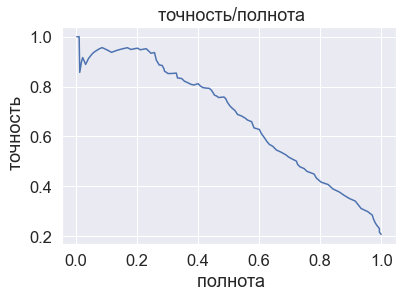

In [109]:
precision_recall_draw(y_test, y_pred_rf, precision_rf, recall_rf)

Построение ROC AUC кривой

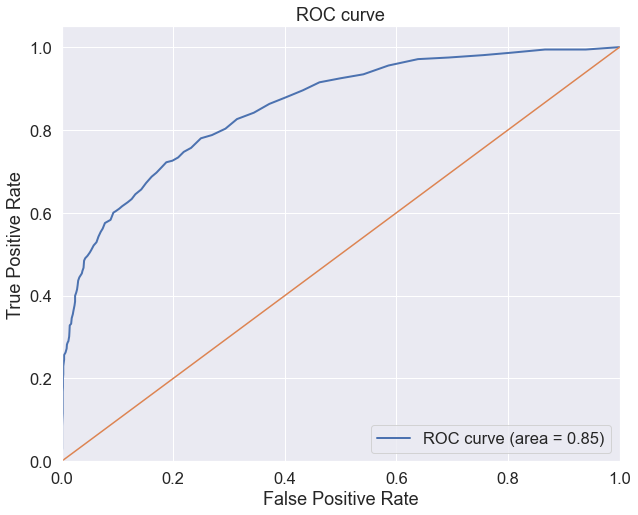

In [137]:
auc_rf = roc_auc_curve_draw(y_test, y_pred_rf)

In [166]:
results_df = results_df.append({'Model':'Random Forest', 
                   'threshold':thresholds_rf[ix_rf], 
                   'Recall': recall_rf[ix_rf], 
                   'Precision':precision_rf[ix_rf], 
                   'F1 max':fscore_rf[ix_rf],
                    'Auc' : auc_rf}
                  , ignore_index=True)

### Gradient Boosting

Единый пайплайн для градиентного бустинга

In [69]:
pipeline_gb = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(n_estimators = 200, 
                                              random_state = 42,
                                              )),
])

Тренировка модели

In [71]:
pipeline_gb.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

Получение предсказаний

In [73]:
y_pred_gb = pipeline_gb.predict_proba(X_test)[:, 1]
y_pred[:15]

array([0.01, 0.74, 0.03, 0.2 , 0.27, 0.61, 0.1 , 0.05, 0.04, 0.53, 0.31,
       0.02, 0.52, 0.09, 0.22])

Определение метрик для последующего анализа.

In [313]:
precision_gb, recall_gb, thresholds_gb = precision_recall_curve(y_test, y_pred_gb)

In [314]:
fscore_gb = (2 * precision_gb * recall_gb) / (precision_gb + recall_gb)

Определение индекса и связанных величин для высшего значения F1 метрики

In [315]:
ix_gb = np.argmax(fscore_gb)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_gb[ix_gb], 
                                                                        fscore_gb[ix_gb],
                                                                        precision_gb[ix_gb],
                                                                        recall_gb[ix_gb]))

Best Threshold=0.324409, F-Score=0.636, Precision=0.651, Recall=0.622


Построение матрицы ошибок

Confusion matrix, without normalization
[[1809  173]
 [ 197  321]]


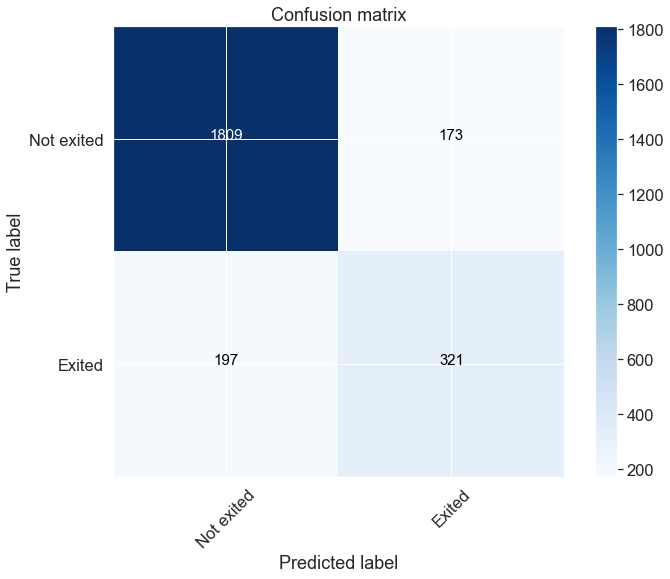

In [318]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_gb = confusion_matrix(y_test, y_pred_gb>thresholds_gb[ix_gb])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_gb, classes=['Not exited', 'Exited'],
                      title='Confusion matrix')
#plt.savefig("conf_matrix.png")
plt.show()

Построение графика точность/полнота

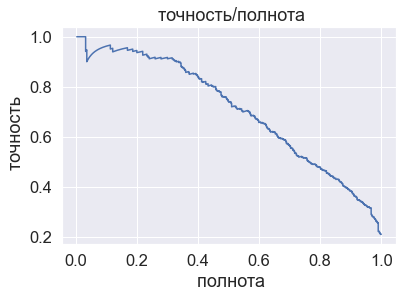

In [113]:
precision_recall_draw(y_test, y_pred_gb, precision_gb, recall_gb)

Построение ROC AUC кривой

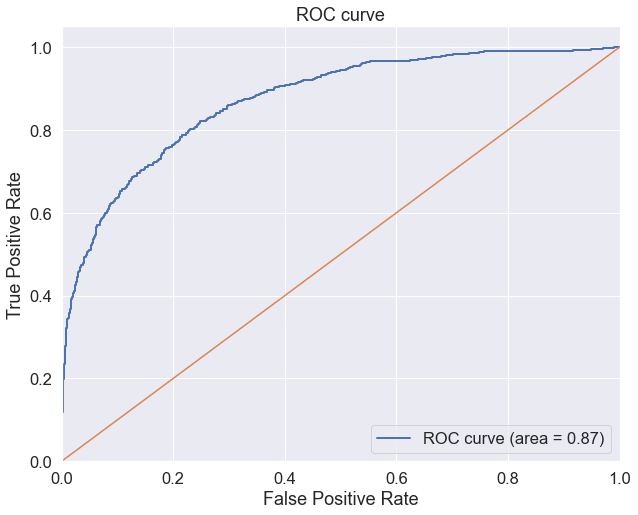

In [161]:
auc_gb = roc_auc_curve_draw(y_test, y_pred_gb)

Добавление результатов в датафрэйм

In [164]:
results_df = results_df.append({'Model':'Gradient Boosting', 
                   'threshold':thresholds_gb[ix_gb], 
                   'Recall': recall_gb[ix_gb], 
                   'Precision':precision_gb[ix_gb], 
                   'F1 max':fscore_gb[ix_gb],
                    'Auc' : auc_gb}
                  , ignore_index=True)

In [167]:
results_df.head()

,Model,threshold,Recall,Precision,F1 max,Auc
0,Gradient Boosting,0.324409,0.621622,0.650505,0.635735,0.872568
1,Random Forest,0.370000,0.575290,0.659292,0.614433,0.853871


----------

## Задание 2

2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)

Таблица результатов

In [168]:
results_df

,Model,threshold,Recall,Precision,F1 max,Auc
0,Gradient Boosting,0.324409,0.621622,0.650505,0.635735,0.872568
1,Random Forest,0.370000,0.575290,0.659292,0.614433,0.853871


По результатам моделей со случайно выбранными параметрами градиентный бустинг показал более высокое значение по обеим метрикам для данной задачи.  
Поэтому для дальнейшего выполнения домашнего задания пример градиентный бустинг в качестве основной модели.

--------------

## Задание 3

3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты. 


Продублируем Confusion Matrix для оптимального порога с точки зрения ML

Confusion matrix, without normalization
[[1809  173]
 [ 197  321]]


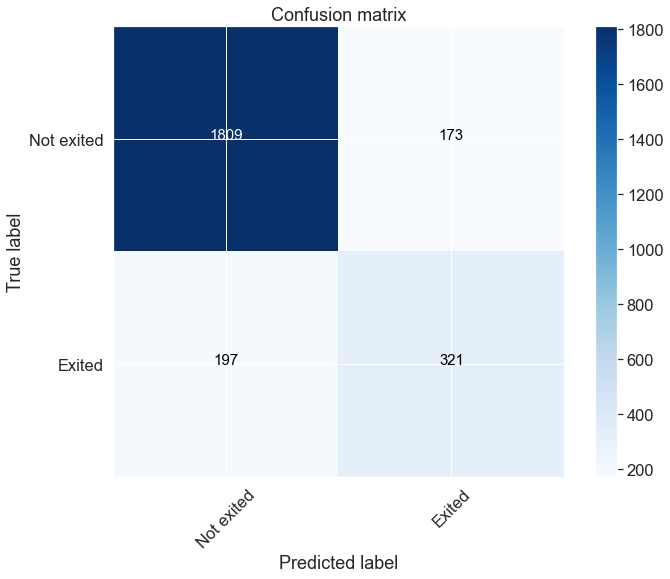

In [319]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_gb = confusion_matrix(y_test, y_pred_gb>thresholds_gb[ix_gb])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_gb, classes=['Not exited', 'Exited'],
                      title='Confusion matrix')
#plt.savefig("conf_matrix.png")
plt.show()

Расходы по деньгам, если все деньги пустить на удержание:

In [311]:
y_test.value_counts()

0    1982
1     518
Name: Exited, dtype: int64

In [312]:
y_test.shape[0]

2500

Лучшие параметры с точки зрения модели

In [316]:
ix_gb = np.argmax(fscore_gb)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_gb[ix_gb], 
                                                                        fscore_gb[ix_gb],
                                                                        precision_gb[ix_gb],
                                                                        recall_gb[ix_gb]))

Best Threshold=0.324409, F-Score=0.636, Precision=0.651, Recall=0.622


Вывод параметров матрицы

In [320]:
tp = cnf_matrix_gb[0, 0]
tp

1809

In [322]:
fp = cnf_matrix_gb[1, 0]
fp

197

In [323]:
fn = cnf_matrix_gb[0, 1]
fn

173

In [324]:
tn = cnf_matrix_gb[1, 1]
tn

321

Расчет экономических параметров с точки зрения оптимального порога по ML

In [342]:
money = 1
keep = 2

In [356]:
def business(money, keep, cnf_matrix):
    tp = cnf_matrix[0, 0]
    fp = cnf_matrix[1, 0]
    fn = cnf_matrix[0, 1]
    tn = cnf_matrix[1, 1]
    
    # доход в идеальном случае
    earnings_ideal = 2500 * money
    print(f"доход в случае 100% сохранения клиентов {earnings_ideal}")
    
    #доход в случае отсутсвия затрат на удержание клиентов без затрат на привлечение новых
    earnings_free = (tp + fn)* money
    print(f"Доход с клиентов, которые точно останутся {earnings_free}")
    
    #доход в случае затрат на удержание FN + TN клиентов за вычетом утраты доходов от FP
    earnings_keep = money * (tp + fn) - keep*(fn + tn) - fp * money
    print(f"доход в случае затрат на удержание клиентов за вычетом дохдов от незамеченных{earnings_keep}")


In [357]:
business(attract, keep, cnf_matrix_gb)

доход в случае 100% сохранения клиентов 2500
Доход с клиентов, которые точно останутся 1982
доход в случае затрат на удержание клиентов за вычетом дохдов от незамеченных797


#### Вывод
Какие-либо выводы по данным значениям сделать очень сложно, т.к. подобные значения имеет смысл рассматривать только в динамике.

--------------------

### Задание 4

4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3


In [213]:
gb_model = GradientBoostingClassifier()

Назначаем список парамеров для перебора

In [258]:
params = {'classifier__learning_rate':[0.05, 0.075, 0.1, 0.125, 0.15],
          'classifier__n_estimators':[50, 150, 200, 250, 500],
          'classifier__max_depth':[2, 3, 4, 5]
}

In [259]:
pipeline_rnd = Pipeline([
    ('features',feats),
    ('classifier',GradientBoostingClassifier())
])

In [260]:
CV = GridSearchCV(pipeline_rnd, params, scoring = 'r2', n_jobs= 1)

Запускаем перебор параметров при помощи Grid Search.  
Работа выполняется через Pipeline

In [262]:
%%time
CV.fit(X_train, y_train)

Wall time: 20min 53s


GridSearchCV(estimator=Pipeline(steps=[('features',
                                        FeatureUnion(transformer_list=[('Geography',
                                                                        Pipeline(steps=[('selector',
                                                                                         FeatureSelector(column='Geography')),
                                                                                        ('ohe',
                                                                                         OHEEncoder(key='Geography'))])),
                                                                       ('Gender',
                                                                        Pipeline(steps=[('selector',
                                                                                         FeatureSelector(column='Gender')),
                                                                                        ('ohe',
              

Лучшие параметры для классиификатора

In [305]:
best_params = CV.best_params_
best_params

{'classifier__learning_rate': 0.1,
 'classifier__max_depth': 3,
 'classifier__n_estimators': 150}

Лучшие параметры достаточно близки к случайно выбранным, поэтому значительное улучшение параметров модели не ожидается.

Получение предсказаний

In [272]:
y_pred_cv = CV.predict_proba(X_test)

In [283]:
y_pred_cv[:15,0]

array([0.95758627, 0.35999344, 0.87423575, 0.79120257, 0.61833919,
       0.46335457, 0.85686928, 0.94710742, 0.97098372, 0.56441168,
       0.69970959, 0.99488271, 0.69630825, 0.90397686, 0.71811951])

In [289]:
precision_cv, recall_cv, thresholds_cv = precision_recall_curve(y_test, y_pred_cv[:,1])

Построение кривой точность-полнота.

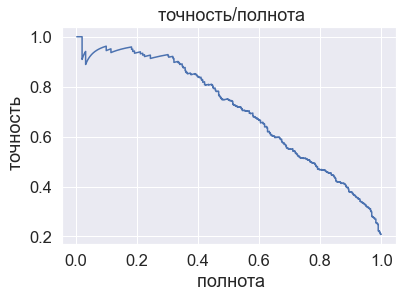

In [290]:
precision_recall_draw(y_test, y_pred_cv, precision_cv, recall_cv)

Построение ROC-AUC кривой

In [291]:
fscore_cv = (2 * precision_cv * recall_cv) / (precision_cv + recall_cv)

In [292]:
ix_cv = np.argmax(fscore_cv)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_cv[ix_cv], 
                                                                        fscore_gb[ix_cv],
                                                                        precision_cv[ix_cv],
                                                                        recall_cv[ix_cv]))

Best Threshold=0.332094, F-Score=0.631, Precision=0.658, Recall=0.612


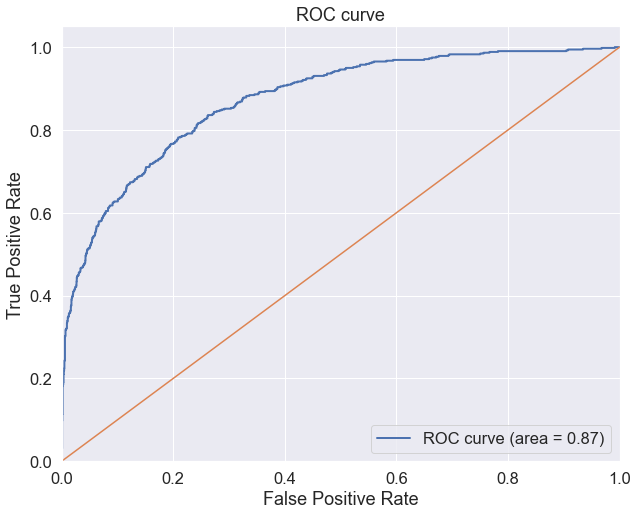

In [300]:
auc_cv = roc_auc_curve_draw(y_test, y_pred_cv[:,1])

Построение матрицы ошибок

Confusion matrix, without normalization
[[1817  165]
 [ 202  316]]


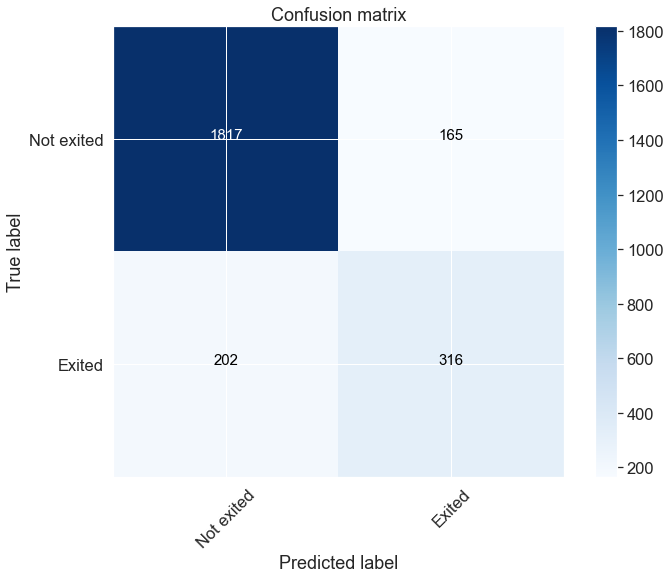

In [354]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_cv = confusion_matrix(y_test, y_pred_cv[:,1]>thresholds_cv[ix_cv])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_cv, classes=['Not exited', 'Exited'],
                      title='Confusion matrix')
#plt.savefig("conf_matrix.png")
plt.show()

In [301]:
results_df = results_df.append({'Model':'Gradient Boosting Grid Search', 
                   'threshold':thresholds_cv[ix_cv], 
                   'Recall': recall_gb[ix_cv], 
                   'Precision':precision_gb[ix_cv], 
                   'F1 max':fscore_gb[ix_cv],
                    'Auc' : auc_cv}
                  , ignore_index=True)

Окончательный вид таблицы с результатами.  
Т.к. параметры эстиматора были изначально достаточно близки к случайно выбранным, то различия находятся в раках статистической погрешности.

In [302]:
results_df

,Model,threshold,Recall,Precision,F1 max,Auc
0,Gradient Boosting,0.324409,0.621622,0.650505,0.635735,0.872568
1,Random Forest,0.370000,0.575290,0.659292,0.614433,0.853871
2,Gradient Boosting Grid Search,0.332094,0.623552,0.639604,0.631476,0.872089


---------

### Задание 5

In [ ]:
5. (опционально) Еще раз провести оценку экономической эффективности

In [358]:
business(attract, keep, cnf_matrix_cv)

доход в случае 100% сохранения клиентов 2500
Доход с клиентов, которые точно останутся 1982
доход в случае затрат на удержание клиентов за вычетом дохдов от незамеченных818


#### Вывод
По сравнению с исходным градиентным бустингом модель дает чуть более высокий процент определения FP величины.  
Благодяря этому единоразовый доход при условии выборочного привлечения новых клиентов получается чуть выше.  
В определенных случаях это может быть оправданно с экономической точки зрения.